# Transformación de colores como transformación lineal (3 filtros)

En esta actividad construimos **3 filtros distintos** (artístico, matemático y experimental) usando una transformación lineal por píxel:

$$
u = A\,v + c,
\qquad 
v=\begin{pmatrix}b\\ g\\ r\end{pmatrix},
\quad
u=\begin{pmatrix}b'\\ g'\\ r'\end{pmatrix}
$$

> **Nota importante (OpenCV):** `cv2.imread` lee los canales en orden **BGR** (azul, verde, rojo), no RGB.

---

## Objetivo

1. Definir \(A\) y \(c\) para un filtro de color.
2. Explicar **algebraicamente** la transformación.
3. Aplicar el filtro a una imagen y comparar **Original vs Transformada**.
4. Repetir para 3 estilos: **Artístico**, **Matemático**, **Experimental**.

---

## 0) Cargar imagen

Este primer bloque importa librerias y carga la imagen seleccionada

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_PATH = "imagen.jpg"  # <- cambia el nombre/ruta si hace falta

print("cwd:", os.getcwd())
print("existe imagen?:", os.path.exists(IMG_PATH))

image_bgr = cv2.imread(IMG_PATH)
if image_bgr is None:
    raise FileNotFoundError(f"No se pudo leer {IMG_PATH}. Revisa nombre/ruta.")

original_bgr = image_bgr.copy()
H, W, _ = image_bgr.shape
(H, W)


cwd: /home/rioabajo/Hybridge/algebra-lineal
existe imagen?: True


(319, 640)

### Funciones auxiliares (para mantener el notebook limpio)

- `apply_filter_linear`: aplica \(u = Av + c\) de forma **vectorizada** (rápida y sin bucles).
- `show_side_by_side`: muestra imágenes lado a lado.


In [1]:
def apply_filter_linear(img_bgr: np.ndarray, A: np.ndarray, c: np.ndarray) -> np.ndarray:
    """Aplica u = A v + c por píxel, con v=[b,g,r]^T (BGR)."""
    H, W, _ = img_bgr.shape
    flat = img_bgr.reshape(-1, 3).astype(np.float32)  # (N,3)
    V = flat.T                                         # (3,N)
    U = (A @ V) + c                                    # (3,N)
    U = np.clip(U, 0, 255).astype(np.uint8)
    return U.T.reshape(H, W, 3)


def show_side_by_side(img1_bgr: np.ndarray, img2_bgr: np.ndarray, title1="Original", title2="Transformada"):
    """Muestra 2 imágenes (BGR) lado a lado usando matplotlib."""
    img1_rgb = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title(title1)
    plt.imshow(img1_rgb)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title(title2)
    plt.imshow(img2_rgb)
    plt.axis("off")
    plt.show()


NameError: name 'np' is not defined

# 1) Filtro Artístico: **Sepia cinematográfico**

### Intuición
El sepia “mezcla” los canales para dar un tono cálido tipo fotografía antigua. Aquí **sí hay mezcla real** entre \(b,g,r\), por eso es un buen ejemplo de transformación lineal.

### Transformación
$$
u = A_{\text{sepia}}\,v + c,
\quad c=\mathbf{0}
$$

donde (en **BGR**):

$$
A_{\text{sepia}}=
\begin{pmatrix}
0.131 & 0.534 & 0.272\\
0.168 & 0.686 & 0.349\\
0.189 & 0.769 & 0.393
\end{pmatrix}
$$

*(Cada canal de salida es combinación lineal de los canales de entrada.)*


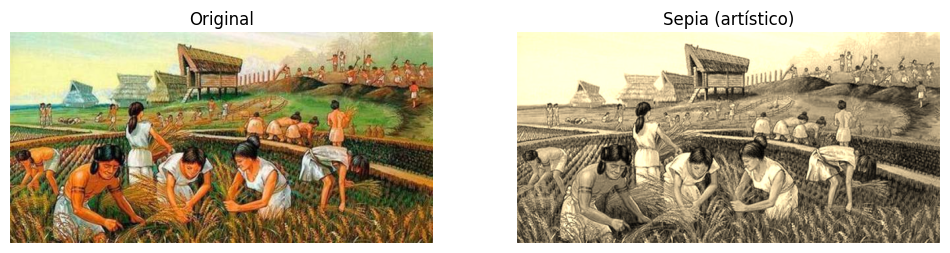

Guardado: out_sepia.jpg


In [3]:
A_sepia = np.array([
    [0.131, 0.534, 0.272],
    [0.168, 0.686, 0.349],
    [0.189, 0.769, 0.393],
], dtype=np.float32)

c0 = np.zeros((3,1), dtype=np.float32)

sepia_bgr = apply_filter_linear(original_bgr, A_sepia, c0)

show_side_by_side(original_bgr, sepia_bgr, title2="Sepia (artístico)")

cv2.imwrite("out_sepia.jpg", sepia_bgr)
print("Guardado: out_sepia.jpg")


# 2) Filtro Matemático: **Proyección a luminancia (gris)**

### Intuición
Convertir a escala de grises puede verse como una **proyección** del vector \(v=(b,g,r)\) a un escalar \(y\) (luminancia),
y luego “replicar” ese escalar en los 3 canales.

Usamos una combinación lineal típica de luminancia (pondera más el verde):

$$
y = 0.114\,b + 0.587\,g + 0.299\,r
$$

Para expresarlo como \(u = Av\), definimos \(A\) para que:

$$
b' = y,\quad g' = y,\quad r' = y
$$

es decir:

$$
A_{\text{gray}}=
\begin{pmatrix}
0.114 & 0.587 & 0.299\\
0.114 & 0.587 & 0.299\\
0.114 & 0.587 & 0.299
\end{pmatrix},
\quad c=\mathbf{0}
$$

Esto es “matemático” porque es una transformación lineal que actúa como **proyección + réplica**.


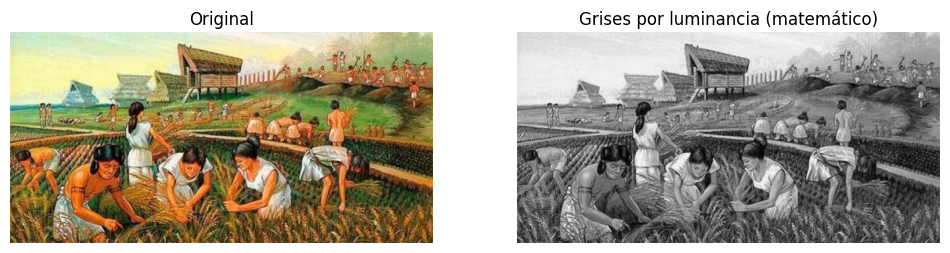

Guardado: out_gray_luminance.jpg


In [4]:
A_gray = np.array([
    [0.114, 0.587, 0.299],
    [0.114, 0.587, 0.299],
    [0.114, 0.587, 0.299],
], dtype=np.float32)

gray_bgr = apply_filter_linear(original_bgr, A_gray, c0)

show_side_by_side(original_bgr, gray_bgr, title2="Grises por luminancia (matemático)")

cv2.imwrite("out_gray_luminance.jpg", gray_bgr)
print("Guardado: out_gray_luminance.jpg")


# 3) Filtro Experimental: **Rotación de canales + sesgo (tinte)**

### Intuición
Aquí hacemos algo “experimental” (no necesariamente realista):

1. **Permutamos (rotamos) canales**: $$b' \leftarrow g,\; g' \leftarrow r,\; r' \leftarrow b$$.
2. Añadimos un **sesgo** \(c\) para dar un tinte extra.

### Transformación
$$
u = A_{\text{rot}}\,v + c
$$

con:
$$
A_{\text{rot}}=
\begin{pmatrix}
0 & 1 & 0\\
0 & 0 & 1\\
1 & 0 & 0
\end{pmatrix},
\qquad
c=
\begin{pmatrix}
10\\
0\\
-10
\end{pmatrix}
$$

Interpretación:
- el nuevo azul toma el valor del verde
- el nuevo verde toma el valor del rojo
- el nuevo rojo toma el valor del azul
- sumamos \(+10\) al azul y \(-10\) al rojo (tinte frío)


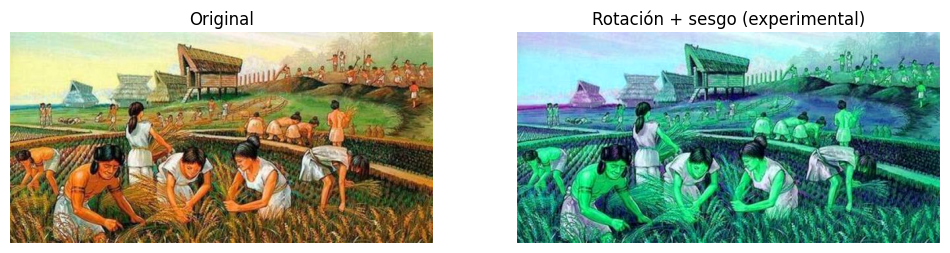

Guardado: out_experimental_rot_bias.jpg


In [5]:
A_rot = np.array([
    [0, 1, 0],
    [0, 0, 1],
    [1, 0, 0],
], dtype=np.float32)

c_exp = np.array([[10.0], [0.0], [-10.0]], dtype=np.float32)

exp_bgr = apply_filter_linear(original_bgr, A_rot, c_exp)

show_side_by_side(original_bgr, exp_bgr, title2="Rotación + sesgo (experimental)")

cv2.imwrite("out_experimental_rot_bias.jpg", exp_bgr)
print("Guardado: out_experimental_rot_bias.jpg")


---
# Resumen rápido

- **Artístico (Sepia):** mezcla canales para producir una tonalidad cálida.
- **Matemático (Grises):** proyección a luminancia y réplica en los 3 canales.
- **Experimental:** permutación de canales + sesgo (tinte).

Todos se expresan como una transformación afín por píxel:

$$
u = A v + c
$$
